## Playground 1/28 - 2/15 : Time-Series Visualizations of Runoff Data

zack sating


- xarray vs netCDF4 [here](https://medium.com/@buzulan.petru/read-and-analyze-netcdf4-files-with-xarray-in-python-1c714fad8a66)
- [some names](https://psl.noaa.gov/data/gridded/data.narr.monolevel.html) for data
- [grid viz](https://cocalc.com/share/public_paths/8b892baf91f98d0cf6172b872c8ad6694d0f7204/notebooks/04.13-Geographic-Data-With-Basemap.ipynb)
- [moving viz](https://medium.com/analytics-vidhya/how-to-read-and-visualize-netcdf-nc-geospatial-files-using-python-6c2ac8907c7c) for india temp using PIL
- [cwrf](http://cwrf.umd.edu) model
- [obs data](https://www.ecad.eu/download/ensembles/download.php) source potentially or just more info on it

useful articles that i used to make the visualizations in this notebook: [a few possibilities with basemap](https://cocalc.com/share/public_paths/8b892baf91f98d0cf6172b872c8ad6694d0f7204/notebooks/04.13-Geographic-Data-With-Basemap.ipynb)
and [some code](https://medium.com/analytics-vidhya/how-to-read-and-visualize-netcdf-nc-geospatial-files-using-python-6c2ac8907c7c) to make animations over time (PIL code similar to what I've written before)

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import PIL.Image
import IPython

## data cleaning + exploration

In [4]:
## i pulled this github repo to my local computer and the dawn server,
## so the other path is where i keep the data I downloaded
IN_DAWN_SERVER = False
if IN_DAWN_SERVER:
  PATH = "/mnt/gfs01/DAWN-ML/"
else:
  PATH = "./"

In [5]:
ds = xr.open_dataset(PATH+"NLDAS_BGRUN_monthly.nc")
df = ds.to_dataframe()
ds

<xarray.Dataset>
Dimensions:  (time: 436, west_east: 138, south_north: 195)
Coordinates:
  * time     (time) int32 197901 197902 197903 197904 ... 201502 201503 201504
Dimensions without coordinates: west_east, south_north
Data variables:
    BGRUN    (time, west_east, south_north) float32 -999.0 -999.0 ... -999.0
    CLAT     (west_east, south_north) float32 15.38 15.46 15.53 ... 49.22 49.08
    CLON     (west_east, south_north) float32 -120.7 -120.4 ... -52.47 -52.11

In [6]:
# over 200,000 instances of large runoff
print(f"runoff >  1000: {len(df.loc[df['BGRUN'] >= 1000])}\n")
print(f"runoff == 9999: {len(df.loc[df['BGRUN'] == 9999])}\n")
print(f"difference:     {len(df.loc[(df['BGRUN'] >= 1000) & (df['BGRUN'] < 9999)])}\n")
# only 30k of medium
df.loc[(df['BGRUN'] >= 250) & (df['BGRUN'] < 1000)]

runoff >  1000: 2227311

runoff == 9999: 2022168

difference:     205143



BGRUN       CLAT        CLON
time   west_east south_north                                   
197901 26        91           431.042267  25.952103  -97.265259
       28        52           942.479492  25.514381 -108.718277
       29        85           389.923737  26.693882  -99.068115
       35        140          386.730988  27.432705  -82.528748
                 155          582.093811  26.680737  -78.127075
...                                  ...        ...         ...
201504 124       84           687.934631  52.824249 -101.467438
                 86           346.447388  52.862362 -100.552032
       128       153          851.314514  51.576641  -70.035522
       129       156          388.117249  51.572151  -68.621735
                 157          992.673157  51.479923  -68.200409

[36061 rows x 3 columns]

So we see that most of our high values come from 9999 values, so we'll get rid of those since they're just fill values for any large body of water, as far as I can tell. Let's set those to NaN so they don't appear when we plot them (hopefully?)

In [7]:
from netCDF4 import Dataset
data = Dataset("NLDAS_BGRUN_monthly.nc", "r", format="NETCDF4")

CLAT = data.variables['CLAT'][:]  
CLON = data.variables['CLON'][:]
time = data.variables['time'][:]
bgrun = data.variables['BGRUN'][:]

In [8]:
print(bgrun.shape, CLAT.shape, CLON.shape, time.shape)

(436, 138, 195) (138, 195) (138, 195) (436,)


#### now for cleaning

first let's look at how our data is spread - this is monthly runoff, so the exponential decay makes sense

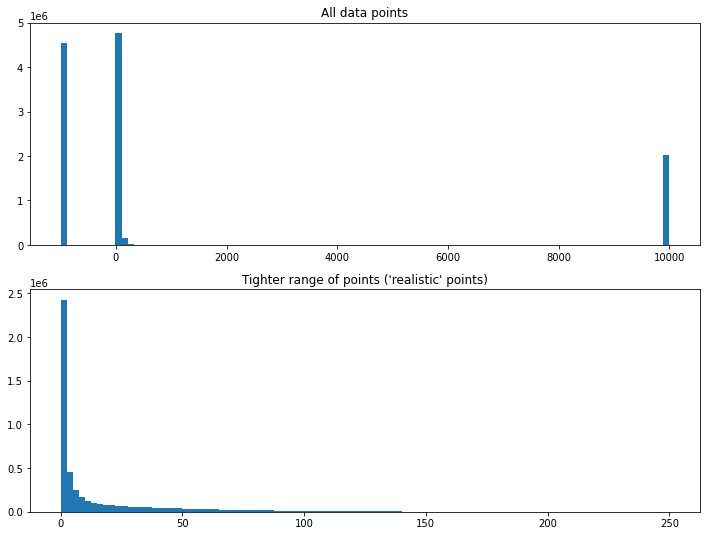

In [9]:
fig, axs = plt.subplots(2,1,figsize=(12,9))

axs[0].hist(df['BGRUN'].to_numpy(), bins=100)
axs[0].set_title("All data points")
axs[1].hist(df['BGRUN'].to_numpy(), bins=100, range=(0,250))
axs[1].set_title("Tighter range of points ('realistic' points)")
plt.show()

### now let's clean our data like we said we would

In [10]:
bgrun[bgrun == -999.0] = np.nan
bgrun[bgrun == 9999.0] = np.nan

In [11]:
print(np.nanmin(bgrun), np.nanmax(bgrun))

0.0 9998.69


Text(0.5, 1.0, 'spread of original data (cleaned)')

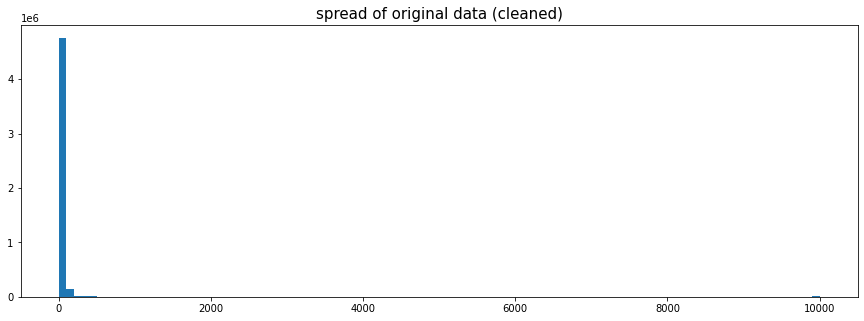

In [12]:
flattened_bgrun = bgrun.flatten()

fig, axs = plt.subplots(figsize=(15,5))
axs.hist(flattened_bgrun, bins=100)
axs.set_title('spread of original data (cleaned)', fontsize=15)
# axs[1].hist(np.log(flattened_bgrun +1), bins=100)
# axs[1].set_title('spread of log data (cleaned)', fontsize=15)

## why might we want to use logarithms for visualizing?

the histogram above seems pretty uninteresting, I don't think anyone can really get much info out of it, so let's see what the logs of all of the monthly runoffs are to combat out exponential decay:

<ipython-input-13-7ae9d630c003>:6: RuntimeWarning: invalid value encountered in log
  axs[1].hist(np.log(flattened_bgrun +1), bins=100)


Text(0.5, 1.0, 'spread of log data (cleaned)')

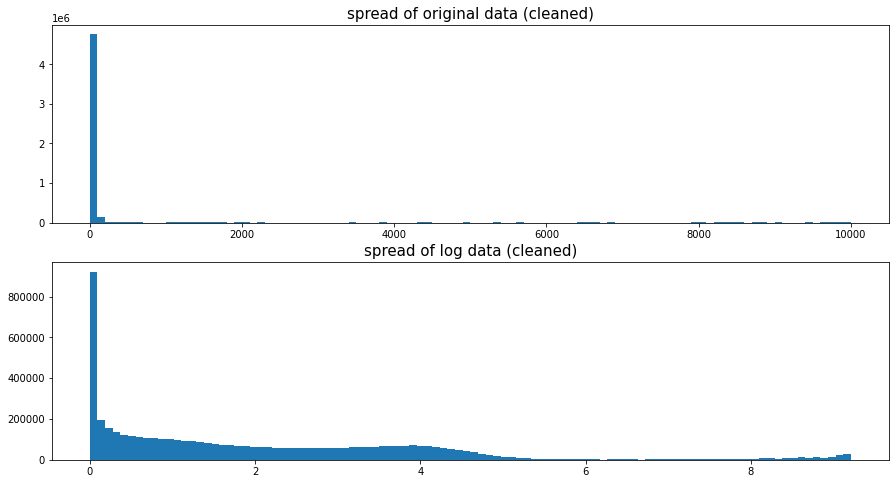

In [13]:
flattened_bgrun = bgrun.flatten()

fig, axs = plt.subplots(2,1,figsize=(15,8))
axs[0].hist(flattened_bgrun, bins=100)
axs[0].set_title('spread of original data (cleaned)', fontsize=15)
axs[1].hist(np.log(flattened_bgrun +1), bins=100)
axs[1].set_title('spread of log data (cleaned)', fontsize=15)

### we can also see this geographically; we don't get any info from the original data, but the log tells us a lot

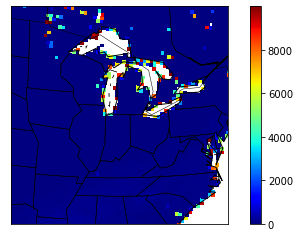

<ipython-input-28-975880de0bdf>:20: RuntimeWarning: invalid value encountered in log
  c_scheme2 = universal_map.pcolormesh(x, y, np.log(bgrun[0] +1), cmap='jet')


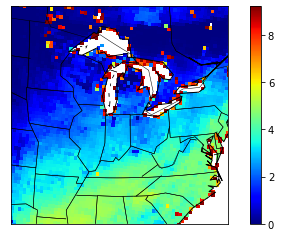

In [28]:
universal_map = Basemap(projection='lcc', resolution='c',
            width= 2E6, height= 2E6, 
            lat_0= 41.70, lon_0= -85.98)

x,y = universal_map(CLON, CLAT) #mapping them together 

# consider this as the outline for the map that is to be created 
universal_map.drawcoastlines()
universal_map.drawstates()
universal_map.drawcountries()

c_scheme1 = universal_map.pcolormesh(x, y, bgrun[0], cmap='jet')
cbar1 = universal_map.colorbar(c_scheme1, location='right', pad='10%') # map information
plt.show()

universal_map.drawcoastlines()
universal_map.drawstates()
universal_map.drawcountries()

c_scheme2 = universal_map.pcolormesh(x, y, np.log(bgrun[0] +1), cmap='jet')
cbar2 = universal_map.colorbar(c_scheme2, location='right', pad='10%') # map information
plt.show()


## use gifs to see how runoff progresses over time

In [15]:
# some helper functions for making images and making them into gifs
def make_geographic_projection_and_save(map: Basemap, x, y, data, title="", savepath="", imgname=""):
  
  map.drawcoastlines()
  map.drawstates()
  map.drawcountries()

  c_scheme = map.pcolormesh(x, y, data, cmap='jet')
  cbar = map.colorbar(c_scheme, location='right', pad='10%')

  plt.title(f"{title} {imgname}")
  plt.savefig(f"{savepath}/{imgname}.png")#, dpi=150)
  plt.clf() # clear figure 
  return plt.figimage

def make_and_display_gif_from_imgs_in_path(path="", filenames=[], duration=100):
  image_frames = []

  for filename in filenames:
    new_frame = PIL.Image.open(f'{path}/{filename}.png') 
    image_frames.append(new_frame)

  image_frames[0].save(f'{path}/test.gif',format='GIF',
                      append_images = image_frames[1: ],
                      save_all = True, duration = duration, loop = 0)

  gif = IPython.display.Image(filename=f'{path}/test.gif')
  IPython.display.display(gif)

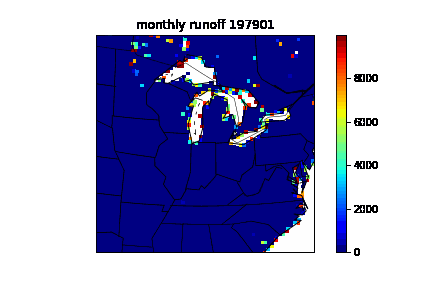

<Figure size 432x288 with 0 Axes>

In [16]:
## ORIGINAL DATA GIF

# testing first 48 months
for i,m in enumerate(time[:48]):
  make_geographic_projection_and_save(universal_map, x, y, bgrun[i], "monthly runoff", "bgrun_imgs", m)
imgnames = [m for m in time[:48]]
make_and_display_gif_from_imgs_in_path(path="bgrun_imgs", filenames=imgnames, duration=100)

### can't tell what's going on

so now let's use our log data to see what's actually happening

<ipython-input-23-6fcb1291e317>:5: RuntimeWarning: invalid value encountered in log
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[i] +1), "monthly runoff", "bgrun_log_imgs", imgname=m)


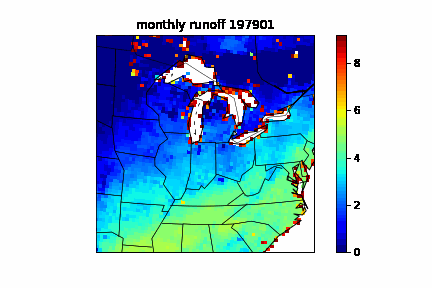

<Figure size 432x288 with 0 Axes>

In [23]:
## DOING LOG VERSION FOR COMPARISON

# showing log of first 48 months
for i, m in enumerate(time[:48]):
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[i] +1), "monthly runoff", "bgrun_log_imgs", imgname=m)

imgnames = [m for m in time[:48]]
make_and_display_gif_from_imgs_in_path(path="bgrun_log_imgs", filenames=imgnames, duration=100)

<ipython-input-22-c1269425f618>:7: RuntimeWarning: invalid value encountered in log
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[12*i] +1), "monthly runoff", "bgrun_log_jan_imgs", imgname=m)


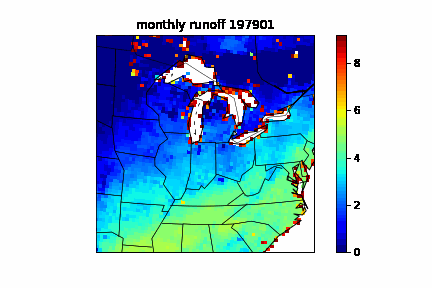

<Figure size 432x288 with 0 Axes>

In [22]:
## since it looks like the up/down motion of the runoff intensity is oscillating by year,
## what i want to do is look at the same month across different years to see if it shifts,
## becomes more intense in some places, etc.

# log of january of each year
for i, m in enumerate(time[::12]):
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[12*i] +1), "monthly runoff", "bgrun_log_jan_imgs", imgname=m)
imgnames = [m for m in time[::12]]
make_and_display_gif_from_imgs_in_path(path="bgrun_log_jan_imgs", filenames=imgnames, duration=150)

one immediate observation I have is that the region in canada above the great lakes goes from a consistently deep blue to a light blue, starting around the mid 90's and is very visible in the 2000's

<ipython-input-19-9e2065f4d7b0>:3: RuntimeWarning: invalid value encountered in log
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[6+12*i] +1), "monthly runoff", "bgrun_log_jul_imgs", imgname=m)


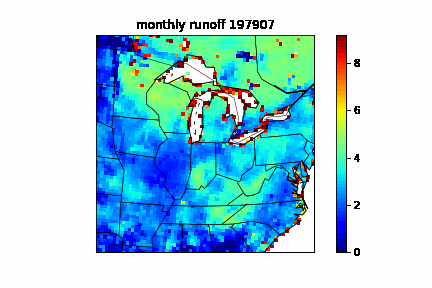

<Figure size 432x288 with 0 Axes>

In [19]:
# log of january of each year
for i, m in enumerate(time[6::12]):
  make_geographic_projection_and_save(universal_map, x, y, np.log(bgrun[6+12*i] +1), "monthly runoff", "bgrun_log_jul_imgs", imgname=m)
imgnames = [m for m in time[6::12]]
make_and_display_gif_from_imgs_in_path(path="bgrun_log_jul_imgs", filenames=imgnames, duration=150)

this is all to demonstrate that there's probably tons of ways that we can use this to get ideas, insight, and just be more accustomed to the (at least .nc) data we're working with